In [1]:
using Images
using TestImages
using FileIO
using Colors
using ImageFeatures
using Formatting
# using Plots
using PyPlot
using DSP
using FixedPointNumbers
using Statistics

┌ Info: Recompiling stale cache file /home/luibo/.julia/compiled/v1.2/ImageFeatures/JMzL1.ji for ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
└ @ Base loading.jl:1187
┌ Warning: Package Distributions does not have Test in its dependencies:
│ - If you have Distributions checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Distributions
└ Loading Test into Distributions from project dependency, future warnings for Distributions are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ImageFeatures [92ff4b2b-8094-53d3-b29d-97f740f06cef]
│   exception = ErrorException("Required dependency Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] failed to load from a cache file.")
└ @ Base loading.jl:972
┌ Info: Recompiling stale cache file /home/luibo/.julia/compiled/v1.2/Distributions/xI

In [2]:
function backwardTransform(algo, M, P, outSize=nothing)
  M = inv(M)
  rows, cols = size(P)
  if outSize == nothing
    outSize = size(P)
  end
  out = zeros(eltype(P), outSize)

  for index in CartesianIndices(out)
    y, x = Tuple(index)
    sourceIndex = M * [x; y; 1]
    sourceIndex ./= sourceIndex[end]
    x1, y1 = round.(Int32, sourceIndex)
    if (x1 < 1 || y1 < 1 || x1 > cols || y1 > rows)
      continue
    end
    out[index] = P[y1, x1]
  end
  out
end

function createProjectiveMatrix(points)
  if length(points) != 4
    error("Not correct number of point")
  end

  A = zeros(Int64, 2*length(points), 8)
  B = zeros(Int64, 2*length(points), 1)
  for i in 1:length(points)
    x, y, x1, y1 = points[i]
    A[2*i - 1,:] = [x y 1 0 0 0 -x*x1 -x1*y]
    A[2*i,:] = [0 0 0 x y 1 -x*y1 -y*y1]
    B[2*i - 1] = x1
    B[2*i] = y1
  end

  H = vcat(A\B, 1)
  reshape(H, (3,3))'
end

function projectiveTransform(picture, points, outSize)
  M = createProjectiveMatrix(points)
  backwardTransform("zero", M, picture, outSize)
end

projectiveTransform (generic function with 1 method)

In [3]:
function hough(img)
  rows, cols = size(img)
  D = round(Int32, sqrt(rows ^ 2 + cols ^ 2))
  rhos = -D:1:D
  thetas = deg2rad.(-90:1:90)

  A = zeros(Int32, length(rhos), length(thetas))
  sins, coss = sin.(thetas), cos.(thetas)
  
  for idx in CartesianIndices(img)
    if img[idx] == 0
      # 0 or false
      continue
    end

    y, x = Tuple(idx)
    for thetaIdx in 1:length(thetas)
      rho = x * coss[thetaIdx] + y * sins[thetaIdx]
      rho = round(Int32, rho)
      A[rho + D, thetaIdx] += 1
    end
  end
  
  rowsA, colsA = size(A)
  for idx in CartesianIndices(A)
    y, x = Tuple(idx)
    if x == 1 || y == 1 || x == colsA || y == rowsA
      continue
    end
    C = A[idx]
    C1 = (C < A[y - 1, x - 1]) || (C < A[y - 1, x])
    C2 = (C < A[y - 1, x + 1]) || (C < A[y, x + 1])
    C3 = (C < A[y + 1, x + 1]) || (C < A[y + 1, x])
    C4 = (C < A[y + 1, x - 1]) || (C < A[y, x - 1])
    if C1 || C2 || C3 || C4
      A[idx] = 0
    end
  end

  A, rhos, thetas
end

hough (generic function with 1 method)

In [4]:
gaussian_kernel = [
  1 4 6 4 1
  4 16 24 16 4
  6 24 36 24 6
  4 16 24 16 4
  1 4 6 4 1
] ./ 256

sobel_x_kernel = [
  -1 0 1
  -2 0 2
  -1 0 1
]
sobel_y_kernel = rotl90(sobel_x_kernel)

3×3 Array{Int64,2}:
  1   2   1
  0   0   0
 -1  -2  -1

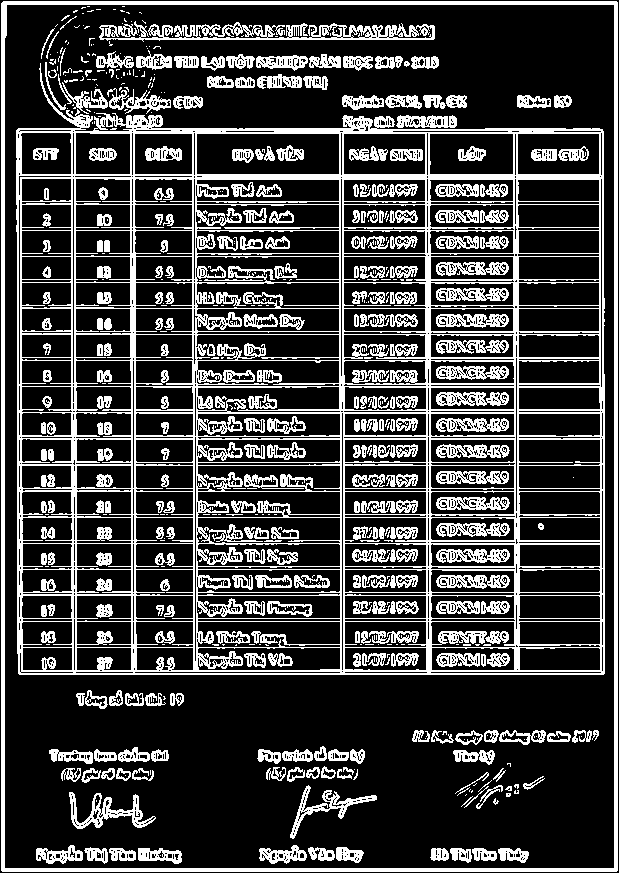

In [5]:
img = load("../images/assignment_1.jpg")
img_gray = Float64.(Gray.(img))
sobel_x_kernel = Float64.(sobel_x_kernel)
sobel_y_kernel = Float64.(sobel_y_kernel)

img_blur = conv2(img_gray, gaussian_kernel)
img_edge_x = conv2(img_blur, sobel_x_kernel)
img_edge_y = conv2(img_blur, sobel_y_kernel)

img_edge = round.(Int32, sqrt.((img_edge_x .^ 2) .+ (img_edge_y .^ 2)))
img_edge[img_edge .> 0] .= 1





img_bool = zeros(Bool, size(img_edge))
img_bool[img_edge .> 0] .= true
display(Gray.(img_edge))
display()

In [6]:
acc, rhos, thetas = hough(img_edge)
for i in 1:50
  r_idx, t_idx = Tuple(argmax(acc))
  acc[r_idx, t_idx] = 0
  display((rhos[r_idx], rad2deg(thetas[t_idx])))
end

(3, 0.0)

(4, 0.0)

(614, 0.0)

(615, 0.0)

(616, 0.0)

(134, 0.0)

(343, 0.0)

(72, 0.0)

(75, 0.0)

(-872, -90.0)

(-871, -90.0)

(-870, -90.0)

(-6, -90.0)

(-5, -90.0)

(131, 0.0)

(340, 0.0)

(3, 90.0)

(4, 90.0)

(868, 90.0)

(869, 90.0)

(870, 90.0)

(-4, -90.0)

(2, 90.0)

(-873, -90.0)

(871, 90.0)

(-3, -90.0)

(1, 90.0)

(426, 0.0)

(-177, -90.0)

(-134, -90.0)

(429, 0.0)

(132, 90.0)

(175, 90.0)

(-675, -90.0)

(-180, -90.0)

(178, 90.0)

(673, 90.0)

(-676, -90.0)

(-673, -90.0)

(-597, -90.0)

(-414, -90.0)

(412, 90.0)

(595, 90.0)

(671, 90.0)

(674, 90.0)

(-623, -90.0)

(-545, -90.0)

(-388, -90.0)

(-310, -90.0)

(308, 90.0)

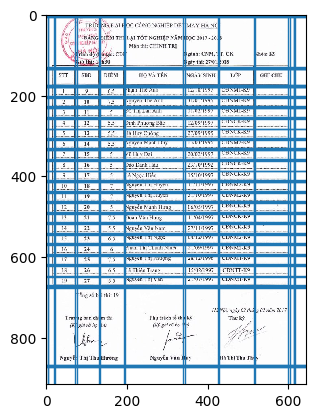

In [7]:
acc, rhos, thetas = hough(img_edge)
rows, cols = size(img)
my_dpi = 96

plt = PyPlot
# PyPlot.svg(true)
plt.figure(figsize=(cols/my_dpi, rows/my_dpi), dpi=my_dpi)

plot_img = plt.imread("source.jpg")
fig, ax = plt.subplots()
# fig = plt.figure(figsize=(cols/2, rows/2))
# fig.set_size_inches(cols,rows)

xs = []
ys = []

ax.imshow(plot_img)
while true
  r_idx, t_idx = Tuple(argmax(acc))
  if (acc[r_idx, t_idx] < 500)
    break
  end
  acc[r_idx, t_idx] = 0

  rho, theta = rhos[r_idx], thetas[t_idx]
  theta = rad2deg(theta)
  # display(theta)
  if (theta == 90 || theta == -90)
    y = rho / sind(theta)
    ax.axhline(y, linewidth=1)
    push!(ys,y)
  elseif (theta == 0)
    x = rho
    ax.axvline(x, linewidth=1)
    push!(xs,x)
  else
    continue
  end
end
savefig("hough.svg", dpi=my_dpi * 20)

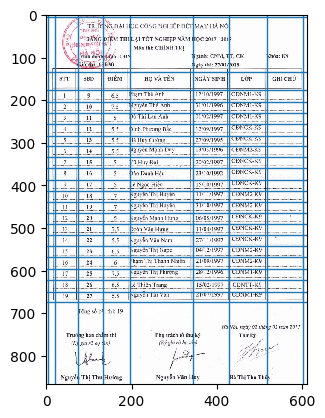

In [8]:
xs = sort(xs)
ys = sort(ys)

function get_arround(arr)
  out = []
  tmp = []
  last = 0
  for val in arr
    if last == 0
      last = val
      continue
    end
    if abs(val - last) < 10
      push!(tmp, val)
    else
      push!(out, round(Int32,mean(tmp)))
      # push!(out, tmp[1])
      tmp = []
    end
    last = val
  end
  out
end

xss = get_arround(xs)
yss = get_arround(ys)
  
# display(xss)
# display(yss)
  
plt.figure(figsize=(cols/my_dpi, rows/my_dpi), dpi=my_dpi)
plot_img = plt.imread("source.jpg")
fig, ax = plt.subplots()
ax.imshow(plot_img)
for y in yss
  ax.axhline(y, linewidth=1)
end
for x in xss
  ax.axvline(x, linewidth=1)
end
savefig("better_hough.svg", dpi=my_dpi * 20)

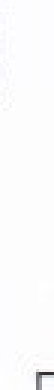

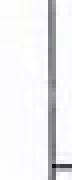

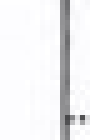

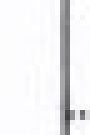

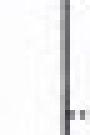

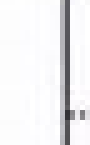

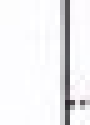

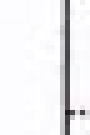

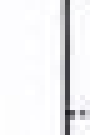

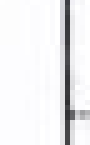

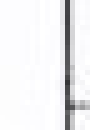

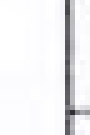

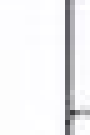

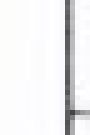

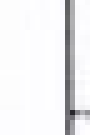

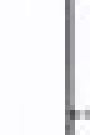

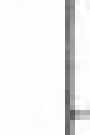

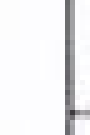

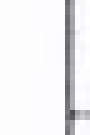

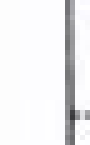

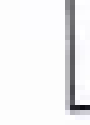

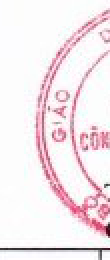

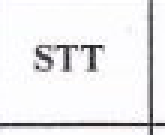

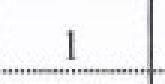

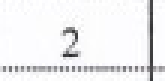

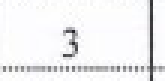

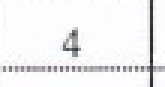

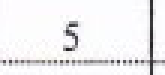

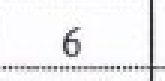

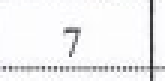

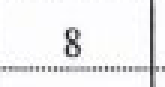

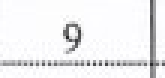

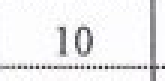

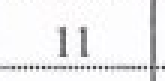

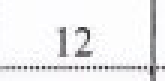

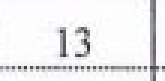

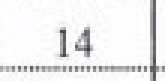

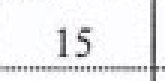

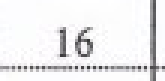

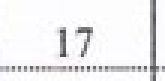

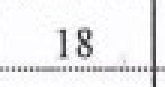

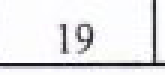

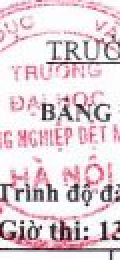

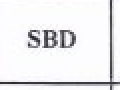

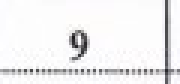

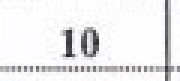

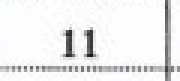

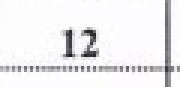

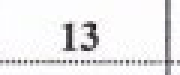

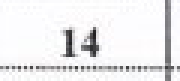

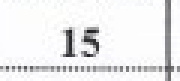

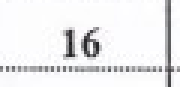

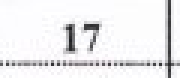

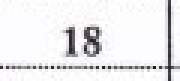

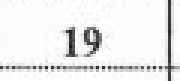

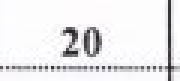

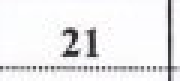

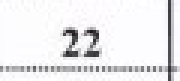

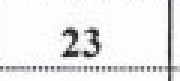

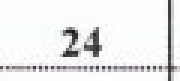

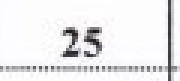

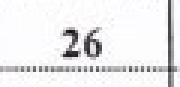

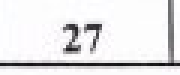

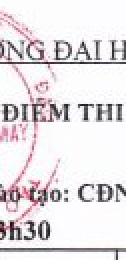

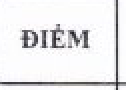

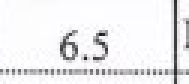

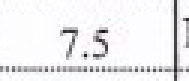

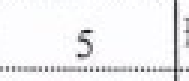

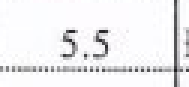

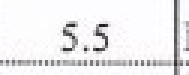

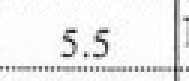

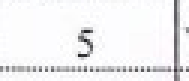

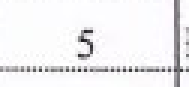

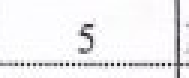

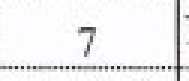

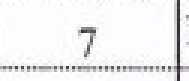

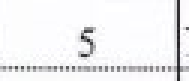

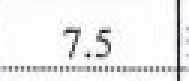

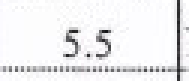

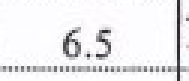

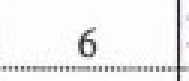

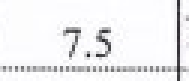

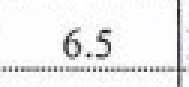

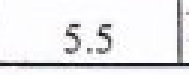

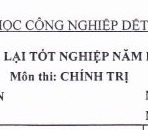

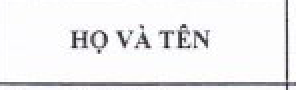

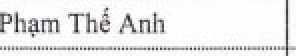

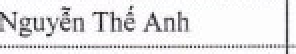

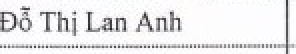

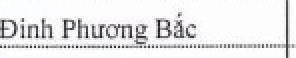

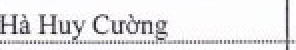

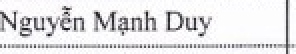

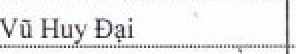

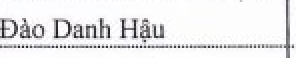

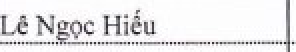

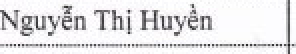

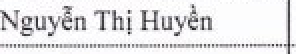

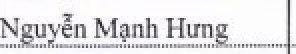

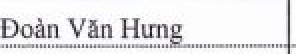

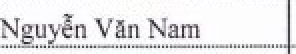

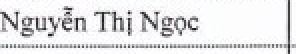

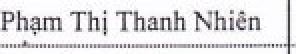

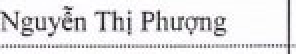

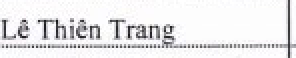

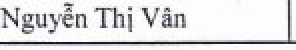

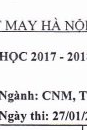

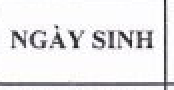

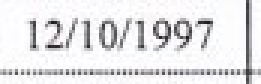

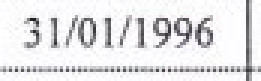

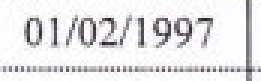

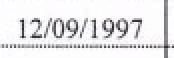

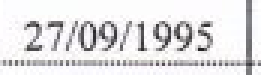

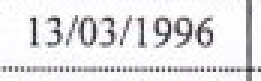

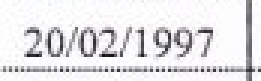

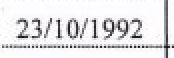

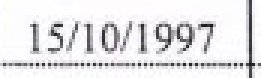

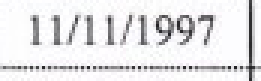

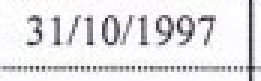

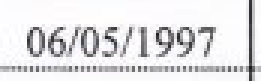

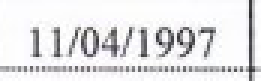

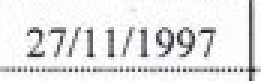

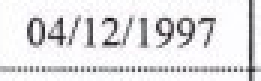

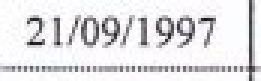

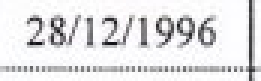

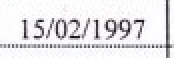

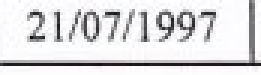

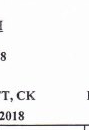

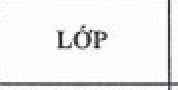

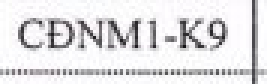

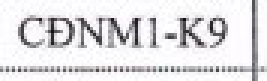

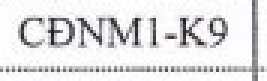

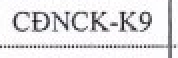

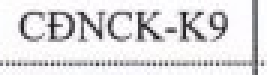

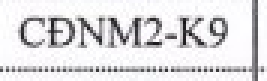

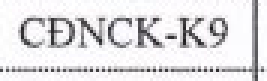

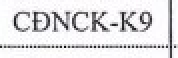

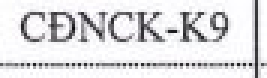

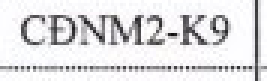

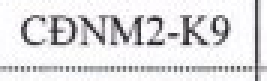

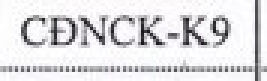

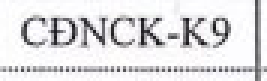

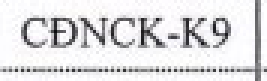

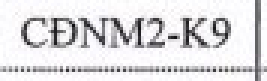

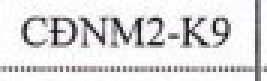

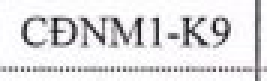

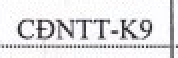

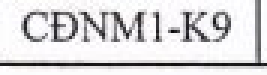

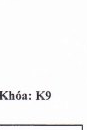

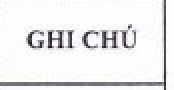

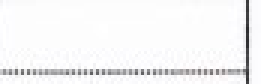

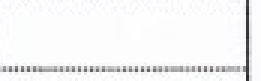

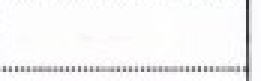

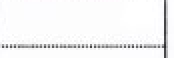

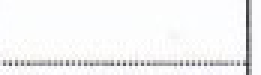

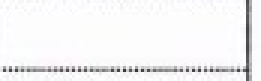

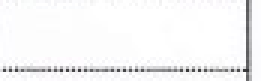

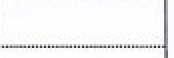

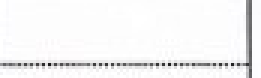

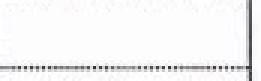

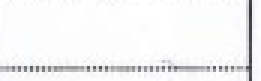

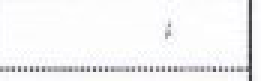

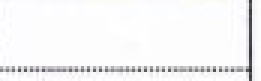

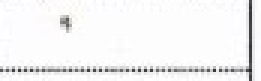

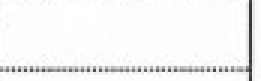

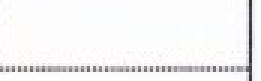

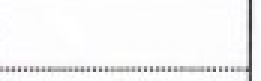

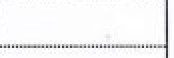

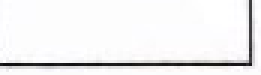

In [9]:
rm("output", recursive=true, force=true)
mkdir("output")

sub_imgs = []
for i in 2:length(xss)
  mkpath("output/$(i-1)")
  # display((i, !(i in [3,4,5,7])))
#   if (!(i in [3,4,5,7,8]))
#     continue
#   end
  for j in 2:length(yss)
#     if j < 4
#       continue
#     end
    c = xss[i-1]:xss[i]
    r = yss[j-1]:yss[j]
    sub_img = img[r,c]
    push!(sub_imgs, sub_img)
    display(sub_img)
    # display("======================")
    save("output/$(i-1)/$(j-1).png", sub_img)
  end
end

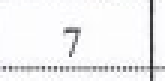

55-element Array{Float64,1}:
 26.290196078431375
 25.725490196078432
 26.462745098039218
 25.647058823529413
 26.34901960784314 
 26.015686274509807
 26.341176470588238
 25.968627450980396
 26.254901960784316
 25.90588235294118 
 26.090196078431376
 26.250980392156865
 25.972549019607847
  ⋮                
 25.67058823529412 
 26.403921568627453
 25.627450980392158
 26.439215686274512
 25.690196078431377
 26.22745098039216 
 25.545098039215688
  6.231372549019608
 24.164705882352944
 25.98039215686275 
 26.01960784313726 
 26.117647058823533

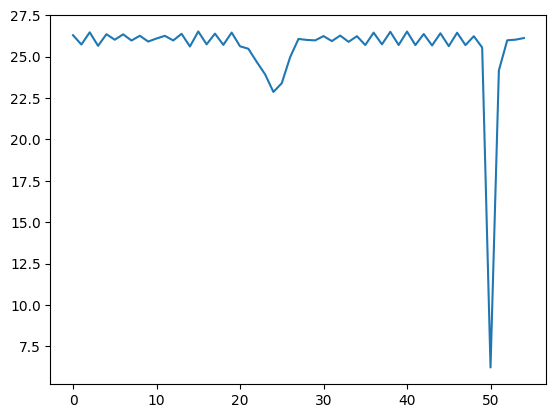

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa217869160>

In [22]:
sub_img = sub_imgs[30]
display(sub_img)
sub_img = Float64.(Gray.(sub_img))
gray_point = vec(sum(sub_img, dims=1))
# gray_point = conv(gray_point, [1.,2.,-1.])
display(gray_point)
plt.plot(gray_point)